# Import librairies

In [1]:
import os

seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)

import sys
import random

sys.path.append("../utile")
sys.path.append("..")
from database import create_cnx, config_parse
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


path = "../data"
plt.rcParams["figure.figsize"] = (15, 15)
import base64

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Concatenate,
    Flatten,
    Dense,
    Dropout,
)

from tensorflow import keras
from tensorflow.keras import Model, regularizers
from sklearn.cluster import KMeans
import keras.backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import InputSpec


from model import Deep_Embedding_Model, DEC
from data import DataSet

from tqdm import tqdm


from difflib import get_close_matches

# from collections import defaultdic

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

2022-03-07 18:08:27.762374: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
print(tf.config.list_physical_devices())

# print(K._get_available_gpus())

2022-03-07 18:08:38.656892: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-03-07 18:08:39.361708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-07 18:08:39.361790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 3060 Ti computeCapability: 8.6
coreClock: 1.665GHz coreCount: 38 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-07 18:08:39.361914: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-07 18:08:39.746091: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-03-07 18:08:39.746262: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-03-07 18:08:39.864446: I tensorflow/stream

# Loading data and utile functions

## Loading data from database

In [3]:
# Select the data for a given season
parser = config_parse()
cnx = create_cnx(parser)["cnx"]
curs = cnx.cursor()
season = {kharif}
sql_request = f"""SELECT DISTINCT * from data_SCOR WHERE Season = "{season}" ORDER BY RAND() LIMIT 10000"""
curs.execute(sql_request)
names = [x[0] for x in curs.description]
rows = curs.fetchall()
df = pd.DataFrame(rows, columns=names)
numeric_features = [
    "Area_Sown_Ha",
    "Area_Insured_Ha",
    "SI_Per_Ha_Inr_Ha",
    "Sum_Insured_Inr",
    "Indemnity_Level",
]
textual_features = [
    "District",
    "Sub_District",
    "Crop",
    "Block",
    "State",
    "Cluster",
]
df = DataSet(
    numeric_features=numeric_features,
    textual_features=textual_features,
    data=rows,
    columns=names,
)
# df = pd.DataFrame(rows, columns=names)
df.drop("id", inplace=True, axis=1)
df.dropna(axis=0, how="all", inplace=True)
# df.drop(axis=1,labels='index', inplace=True)
print(len(df))

10000


/appli/notebooks/../utile/data.py:63: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.numeric_features = numeric_features
/appli/notebooks/../utile/data.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.textual_features = textual_features
/appli/notebooks/../utile/data.py:66: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.values_list_to_replace = values_list_to_replace


In [4]:
df_copy = DataSet(
    numeric_features=numeric_features,
    textual_features=textual_features,
    data=rows,
    columns=names,
)
# df.melt(id_vars=["location", "name"],
#         var_name="Date",
#         value_name="Value")
df_copy.set_years_to_keep()

/appli/notebooks/../utile/data.py:101: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.years_crop_yields = [f"{year}_Yield" for year in years_to_keep]


In [5]:
len(df)

10000

## Import images paths

In [6]:
# path = '../image_data/data'
# list_directories = os.listdir(path)

# Get all files paths to join SCOR datasets and images
names_file = (
    pd.read_csv(
        "../pre_trained_models/Encoder_prediction/list_files.csv",
        names=["id", "path"],
        header=None,
    )[1:]
    .drop(columns=["id"])
    .reset_index(drop=True)
)
list_directories = names_file["path"].tolist()

In [7]:
# Define custom class Dataset with the usefull features
numeric_features = [
    "Area_Sown_Ha",
    "Area_Insured_Ha",
    "SI_Per_Ha_Inr_Ha",
    "Sum_Insured_Inr",
    "Indemnity_Level",
]
textual_features = [
    "District",
    "Sub_District",
    "Crop",
    "Block",
    "State",
    "Cluster",
]
ohe_features = ["year"]
df = DataSet(
    numeric_features=numeric_features,
    textual_features=textual_features,
    ohe_features=ohe_features,
    data=df,
    columns=df.columns,
)
years_yield = np.arange(2000, 2019, 1)
YEARS = [f"{year}_Yield" for year in years_yield]
# print(df_copy.years_crop_yields, YEARS)
# df.drop(columns=list(set(YEARS) - set(df_copy.years_crop_yields)), inplace=True)
df = df.rename(columns={year: year[:4] for year in df_copy.years_crop_yields})

/appli/notebooks/../utile/data.py:65: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.ohe_features = ohe_features


In [11]:
# Unpivot dataset to use images for each year
df = df.melt(
    id_vars=list(
        set(df.columns) - set([year[:4] for year in df_copy.years_crop_yields])
    ),
    var_name="year",
    value_name="label",
)

In [12]:
# Define images path names to link to encoded satellite images
season = "kharif"
seasons_date = {"kharif": ["-04-16", "-10-15"], "rabi": ["-10-16", "-04-15"]}


def set_image_path(x):
    state, district = x["State"], x["District"]
    name = f"('{state.title()}', '{district.title()}')"
    year = x["year"]
    if season == "kharif":
        s0, s1 = seasons_date[season][0], seasons_date[season][1]
        date = f"'{year}{s0}', '{year}{s1}'"
    elif season == "rabi":
        s0, s1 = seasons_date[season][0], season_date[season][1]
        date = f"'{year}{s0}', '{year+1}{s1}'"

    return f"../image_data/data/[{date}]_{name}.png"


df["image"] = df.apply(set_image_path, axis=1)

In [15]:
from os import path

compt = 0
regions = []
# Identify regions that are not recognized within images files
for i in range(len(df)):
    if not path.exists(df.iloc[i]["image"]):
        compt += 1
        elem = [df.iloc[i]["State"], df.iloc[i]["District"]]
        if elem not in regions:
            regions.append(elem)
        # districts.append(df.iloc[i]["District"])
# regions = set(regions)

# Identify states/districts that are in the images datasets
list_directories_state = []
list_directories_district = []
char_to_replace = ["(", ")", ".png", "'"]
for elem in list_directories:
    a = elem.split("_")[1]
    for char in char_to_replace:
        a = a.replace(char, "")
    # Get names of states
    list_directories_state.append([elements.lstrip() for elements in a.split(",")][0])
    # Get names of districts
    list_directories_district.append(
        [elements.lstrip() for elements in a.split(",")][1]
    )
# Set of states/districts (to delete duplicates)
list_directories_state = set(list_directories_state)
list_directories_district = set(list_directories_district)

# States districts not recognized
states_not_recognized = [r[0].title() for r in regions]
district_not_recognized = [r[1].title() for r in regions]
district_not_recognized = set(district_not_recognized)
# Some districts didn't match at all, so we manually pick nearest districts to replace them
district_to_replace = {
    "Hooghly": "Hugli",
    "Peddapalli": "Karimnagar",
    "Cuddapah": "Kurnool",
    "Beed": "Bid",
}

# Set dictionnary for fuzzy match for districts between SCOR dataset and images dataset
changes_district = {}
for district in district_not_recognized:
    if district in district_to_replace.keys():
        changes_district[district] = district_to_replace[district]
    elif district not in list_directories_district:
        if get_close_matches(district, list_directories_district):
            changes_district[district] = get_close_matches(
                district, list_directories_district
            )[0]
        else:
            try:
                changes_district[district] = get_close_matches(
                    district.split(" ")[0], list_directories_district
                )[0]
                # print()
            except:
                prin("error")

In [17]:
season = "kharif"
df.dropna(subset=["label"], inplace=True)
seasons_date = {"kharif": ["-04-16", "-10-15"], "rabi": ["-10-16", "-04-15"]}

# Readjust the name of the path for each mismatching file
def set_image_path(x):
    state, district = x["State"], x["District"]
    try:
        changes_district[district]
    except:
        pass
    name = f"('{state.title()}', '{district.title()}')"
    year = x["year"]
    if season == "kharif":
        s0, s1 = seasons_date[season][0], seasons_date[season][1]
        date = f"'{year}{s0}', '{year}{s1}'"
    elif season == "rabi":
        s0, s1 = seasons_date[season][0], season_date[season][1]
        date = f"'{year}{s0}', '{year+1}{s1}'"

    return f"../image_data/data/[{date}]_{name}.png"


df["image"] = df.apply(set_image_path, axis=1)

## Import images encodings

In [18]:
# Get encoded images and their corresponding names
names_file = (
    pd.read_csv(
        "../pre_trained_models/Encoder_prediction/list_files.csv",
        names=["id", "path"],
        header=None,
    )[1:]
    .drop(columns=["id"])
    .reset_index(drop=True)
)
matrix_images = np.load("../pre_trained_models/Encoder_prediction/encoding_array.npy")

In [19]:
# Set the path to get the image
names_file["path"] = names_file["path"].apply(lambda x: "../image_data/" + x)

# Preprocessing and encoding

## Pre-processing

In [20]:
# Define custom class Dataset with the usefull features
numeric_features = [
    "Area_Sown_Ha",
    "Area_Insured_Ha",
    "SI_Per_Ha_Inr_Ha",
    "Sum_Insured_Inr",
    "Indemnity_Level",
]
textual_features = [
    "District",
    "Sub_District",
    "Crop",
    "Block",
    "State",
    "Cluster",
]
ohe_features = ["year"]
df.reset_index(inplace=True, drop=True)
df = DataSet(
    numeric_features=numeric_features,
    textual_features=textual_features,
    ohe_features=ohe_features,
    data=df,
    columns=df.columns,
)

In [21]:
# Keep only crop yields years with enough data
# df.set_years_to_keep()
# Subset dataframe to keep only numeric features, textual features, and crop yields years
# df.subset_data()
# Preprocxess numeric features
df.pre_process_numeric()
# Preprocess textual features
df.preprocess_textual()

/appli/notebooks/../utile/data.py:171: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  indx_non_null_other = reduce(


In [22]:
len(df)

59192

## Encoding

In [23]:
df.set_dict_shape()
# Encode OHE feature
df.encode_ohe()
# Encode textual feature
df.encode_textual()

/appli/notebooks/../utile/data.py:219: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.dict_shape = dict_shape
/appli/notebooks/../utile/data.py:237: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.L_OHE = L_OHE
/appli/notebooks/../utile/data.py:256: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.vocab = vocab


In [24]:
dict_shape = df.dict_shape

In [25]:
df.columns

Index(['District', 'SI_Per_Ha_Inr_Ha', 'Crop', '2017_Yield', '2007_Yield',
       '2008_Yield', 'Area_Insured_Ha', 'Cluster', '2003_Yield', '2002_Yield',
       '2006_Yield', '2004_Yield', '2000_Yield', '2016_Yield', 'State', 'GP',
       'Indemnity_Level', '2018_Yield', '2009_Yield', '2001_Yield',
       '2005_Yield', 'Sum_Insured_Inr', 'Block', 'Area_Sown_Ha', 'Season',
       'Sub_District', 'label', 'image', 'year_2010', 'year_2011', 'year_2012',
       'year_2013', 'year_2014', 'year_2015'],
      dtype='object')

# Regression Model

In [27]:
# Define model
from model import Deep_Embedding_Model

Dense_embedding_model = Deep_Embedding_Model(
    dict_shape=dict_shape,
    textual_features=textual_features,
    numeric_features=numeric_features,
    # ohe_features=df.L_OHE[0].tolist(),
    outputs_shape=1,
    image=True,
).model()

2022-03-07 18:26:05.965014: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-07 18:26:05.971849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-07 18:26:05.972441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 3060 Ti computeCapability: 8.6
coreClock: 1.665GHz coreCount: 38 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-07 18:26:05.972988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/b

In [28]:
Dense_embedding_model.summary()

Model: "Deep_embedded_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 4, 4, 64)]   0                                            
__________________________________________________________________________________________________
input_District (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_Sub_District (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_Crop (InputLayer)         [(None, 1)]          0                                            
________________________________________________________________________________

## Model train and test

In [30]:
# Keep rows we managed to link to images
df.drop((df[~df["image"].isin(names_file["path"])]).index, inplace=True)
df.reset_index(inplace=True, drop=True)

In [31]:
len(df)

49921

In [34]:
batch_size = 512

# Function to get the encoded image from its names
def find_img(x):
    img_locations = names_file[names_file["path"] == x].index
    im_f = matrix_images[img_locations, :, :, :]
    im_f = np.reshape(im_f, im_f.shape[1:])
    # im_f = np.reshape(im_f, [1]+list(im_f.shape))
    return np.asarray(im_f).astype("float32")


# Get the input for a given batch
def get_inputs(batch_x):
    labels = pd.to_numeric(batch_x["label"])
    # textual_f=numeric_f=ohe_f=None
    if df.textual_features:
        textual_f = {}
        for feature in df.textual_features:
            textual_f[feature] = np.asarray(batch_x[feature]).astype(np.float32)

    if df.numeric_features:
        numeric_f = {}
        for feature in df.numeric_features:
            numeric_f[feature] = np.asarray(batch_x[feature]).astype(np.float32)

    if df.ohe_features:
        ohe_f = {}
        # print(self.df.L_OHE[0].tolist())
        for feature in df.L_OHE[0].tolist():
            ohe_f[feature] = np.asarray(batch_x[feature]).astype(np.float32)
    try:

        # print(np.array(batch_x['image'].apply(find_img).tolist()).shape)
        im_f = np.asarray(batch_x["image"].apply(find_img).tolist()).astype(np.float32)
        # im_f = np.array(batch_x["image"].apply(find_img).tolist())
        # im_f = np.asarray([np.asarray(elem) for elem in im_f])
        # print(im_f.shape)
    except Exception as e:
        print("error", e)
        pass
    inputs = [textual_f, numeric_f, {"img": im_f}]
    # print(inputs)
    # print(inputs[-1])
    return inputs, labels


# Custom generator that yields input for the model for a given batch_size
def generator_custom(df, batch_size):

    start = 0
    end = batch_size

    while end <= len(df) - batch_size:
        # print(start, end, len(df))
        batch_x = df.iloc[start:end]

        yield get_inputs(batch_x)
        start += batch_size
        end += batch_size
    # print(start,len(df))
    batch_x = df.iloc[start:]
    return get_inputs(batch_x)

In [35]:
# Train/ test split
# df.L_OHE = None
# inputs = df.df_train_test_split(flatten=True)
# inputs_train = [
#     inputs["textual"]["train"],
#     inputs["numeric"]["train"],
#     inputs["ohe"]["train"],
# ]


# Train/test split
df.df_train_test_split_index()
train_data = df.iloc[df.index_train].reset_index(drop=True)
train_data = DataSet(
    numeric_features=numeric_features,
    textual_features=textual_features,
    ohe_features=ohe_features,
    data=train_data,
    columns=train_data.columns,
)

test_data = df.iloc[df.index_test].reset_index(drop=True)
test_data = DataSet(
    numeric_features=numeric_features,
    textual_features=textual_features,
    ohe_features=ohe_features,
    data=test_data,
    columns=test_data.columns,
)

train_data.L_OHE = df.L_OHE
test_data.L_OHE = df.L_OHE

# Custom training loop
epochs = 10
for epoch in range(epochs):
    # TODO history = {"loss_value":[],"mae_value":[], "val_loss":[],"val_mae":[]}
    print("\nStart of epoch %d" % (epoch,))
    losses = []
    pbar = tqdm(
        generator_custom(train_data, batch_size),
        total=len(train_data) // batch_size - 1,
        desc="Training",
    )
    for (inputs, outputs) in pbar:
        # print(inputs[-1]["img"].shape)
        Dense_embedding_model.train_on_batch(inputs, outputs)
        logits = Dense_embedding_model(
            inputs, training=True
        )  # Logits for this minibatch

        # Compute the loss value for this minibatch.
        loss_value = tf.keras.losses.MeanSquaredError()(logits, outputs).numpy()
        losses.append(loss_value)
        mae_value = int(loss_value ** (1 / 2))
        pbar.set_postfix({"loss": loss_value, "mae": mae_value})
    loss_value = sum(losses) / len(losses)
    val_losses = []
    for (inputs, outputs) in generator_custom(test_data, batch_size):
        logits = Dense_embedding_model(
            inputs, training=True
        )  # Logits for this minibatch
        loss_value = tf.keras.losses.MeanSquaredError()(logits, outputs).numpy()
        val_losses.append(loss_value)
    val_loss = sum(val_losses) / len(val_losses)
    print(
        f"loss: {int(loss_value)}, val_loss: {int(val_loss)}, mae: {int(loss_value**(1/2))}, val_mae= {int(val_loss**(1/2))} "
    )

/tmp/ipykernel_9875/3795264463.py:38: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  train_data.L_OHE = df.L_OHE
/tmp/ipykernel_9875/3795264463.py:39: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  test_data.L_OHE = df.L_OHE



Start of epoch 0


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:49<00:00,  1.46it/s, loss=1.26e+7, mae=3550]


loss: 2665341, val_loss: 19790070, mae: 1632, val_mae= 4448 

Start of epoch 1


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:48<00:00,  1.47it/s, loss=1.36e+7, mae=3683]


loss: 3426354, val_loss: 20813116, mae: 1851, val_mae= 4562 

Start of epoch 2


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:48<00:00,  1.47it/s, loss=1.22e+7, mae=3491]


loss: 1494398, val_loss: 29609034, mae: 1222, val_mae= 5441 

Start of epoch 3


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:49<00:00,  1.47it/s, loss=1.36e+7, mae=3690]


loss: 1891257, val_loss: 30178462, mae: 1375, val_mae= 5493 

Start of epoch 4


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:51<00:00,  1.40it/s, loss=1.4e+7, mae=3747]


loss: 2029050, val_loss: 32510073, mae: 1424, val_mae= 5701 

Start of epoch 5


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:50<00:00,  1.43it/s, loss=1.78e+7, mae=4215]


loss: 2542697, val_loss: 30628571, mae: 1594, val_mae= 5534 

Start of epoch 6


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:50<00:00,  1.43it/s, loss=1.87e+7, mae=4320]


loss: 2305078, val_loss: 32669558, mae: 1518, val_mae= 5715 

Start of epoch 7


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:52<00:00,  1.38it/s, loss=1.77e+7, mae=4202]


loss: 2261542, val_loss: 33378061, mae: 1503, val_mae= 5777 

Start of epoch 8


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:51<00:00,  1.40it/s, loss=1.61e+7, mae=4011]


loss: 2446759, val_loss: 32494486, mae: 1564, val_mae= 5700 

Start of epoch 9


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:53<00:00,  1.35it/s, loss=2.01e+7, mae=4481]


loss: 2138718, val_loss: 30859366, mae: 1462, val_mae= 5555 


__NB: The model was fitted on very few examples and doesn't convergence. Some adjustements might be done to the model, and the model might be trained on more examples), also to improve results, one might improve the ConvAutoEncoder__

In [36]:
list_embedding_clustering = {}
# Textual feature we want to keep for the clustering space
textual_features_to_keep = ["State", "District", "Sub_District", "Block"]
for feature in textual_features_to_keep:
    # Get trained embedding layer and apply it to the input
    list_embedding_clustering[feature] = Flatten()(
        Dense_embedding_model.get_layer(f"Embedding_{feature}")(
            Dense_embedding_model.input[0][feature]
        )
    )
# If there are several features, concatenate all embeddings
concatted_clustering = Concatenate(name="concatted_clustering")(
    list(list_embedding_clustering.values())
)

# Define the model for the projection of data onto clustering space
model_feature_representation = Model(
    inputs=[Dense_embedding_model.input[0]],
    outputs=concatted_clustering,
    name="model_feature_representation",
)

# CLustering model only with embedding of states district etc.

In [48]:
# Apply embedding projection model to the input
X_train_embedded = model_feature_representation.predict(inputs[0])

uniques = np.unique(X_train_embedded, axis=0)

In [49]:
uniques.shape

(449, 80)

# DEC 

In [50]:
# Define DEC model
DEC_model = DEC(dims=[uniques.shape[1]])
DEC_model.encoder_models()

In [51]:
# Train AE
history = DEC_model.model_AE.fit(
    uniques,
    uniques,
    epochs=75,
    batch_size=128,
    validation_split=0.3,
)

Epoch 1/75
3/3 [==============================] - 0s 66ms/step - loss: 0.1212 - mae: 0.2711 - val_loss: 0.1686 - val_mae: 0.3296
Epoch 2/75
3/3 [==============================] - 0s 18ms/step - loss: 0.1198 - mae: 0.2704 - val_loss: 0.1683 - val_mae: 0.3294
Epoch 3/75
3/3 [==============================] - 0s 18ms/step - loss: 0.1167 - mae: 0.2678 - val_loss: 0.1681 - val_mae: 0.3292
Epoch 4/75
3/3 [==============================] - 0s 18ms/step - loss: 0.1172 - mae: 0.2682 - val_loss: 0.1679 - val_mae: 0.3290
Epoch 5/75
3/3 [==============================] - 0s 19ms/step - loss: 0.1159 - mae: 0.2671 - val_loss: 0.1677 - val_mae: 0.3288
Epoch 6/75
3/3 [==============================] - 0s 22ms/step - loss: 0.1158 - mae: 0.2666 - val_loss: 0.1675 - val_mae: 0.3286
Epoch 7/75
3/3 [==============================] - 0s 19ms/step - loss: 0.1157 - mae: 0.2670 - val_loss: 0.1673 - val_mae: 0.3284
Epoch 8/75
3/3 [==============================] - 0s 18ms/step - loss: 0.1143 - mae: 0.2659 - val

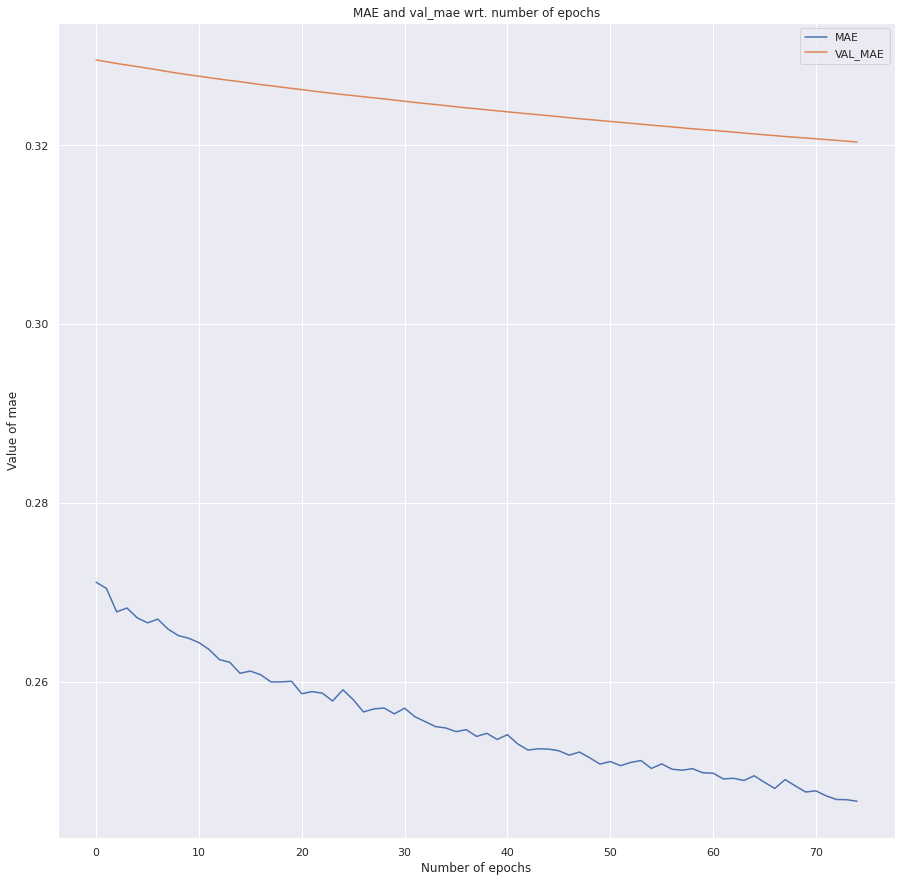

In [52]:
# Visualize training
sns.set_theme()
plt.plot(history.history["mae"], label="MAE")
plt.ylabel("Value of mae")
plt.xlabel("Number of epochs")
# ticks = plt.xticks(np.arange(1, epochs+1))
plt.plot(history.history["val_mae"], label="VAL_MAE")
plt.title("MAE and val_mae wrt. number of epochs")
plt.legend()

In [53]:
# Get encodings from inputs
features = DEC_model.model_Encoder.predict(uniques)

In [54]:
# Apply a Kmeans to visualize quickly results from AE
alpha = 0
n_clusters = 5
input_dim = 2
model_kmeans = KMeans(n_clusters).fit(features)
centroids_init = model_kmeans.cluster_centers_

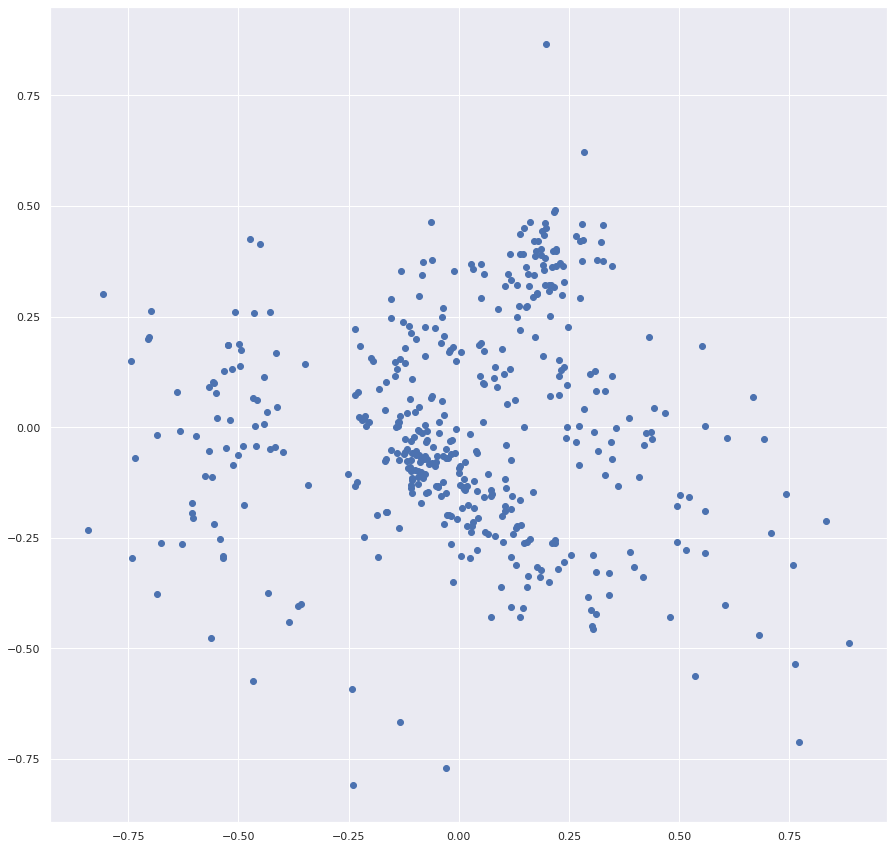

In [55]:
# Visualize embedding after AE
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)
plt.scatter(pca_features[:, 0], pca_features[:, 1])

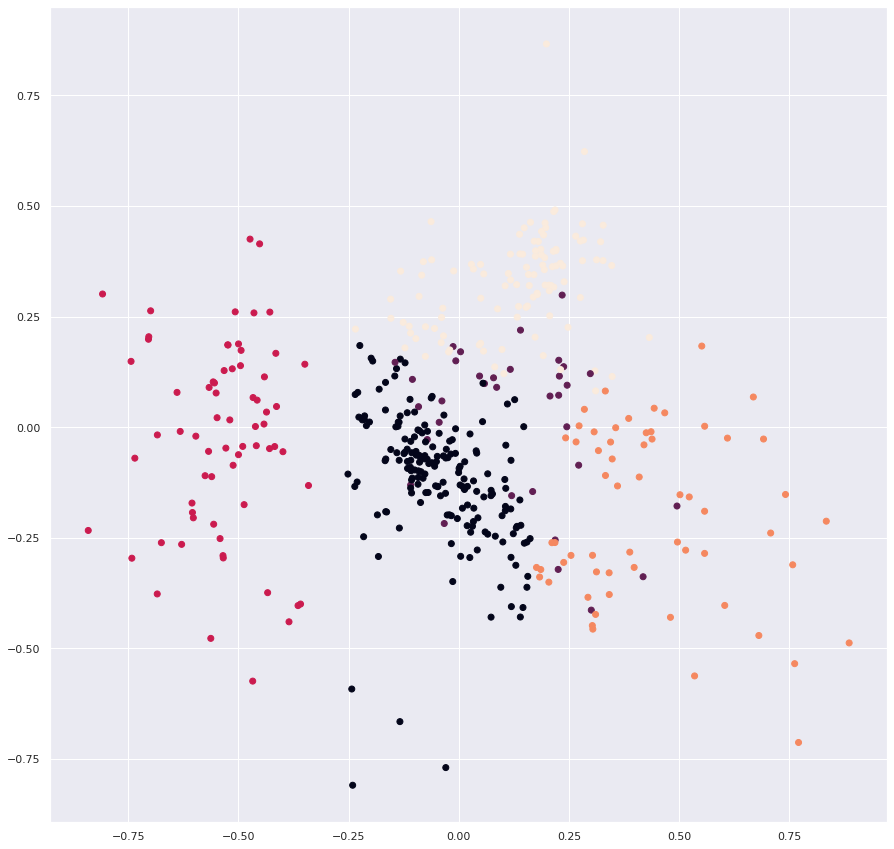

In [56]:
# Visualize embedding after AE with KMeans predictions
plt.scatter(
    pca_features[:, 0], pca_features[:, 1], c=model_kmeans.labels_.astype(float)
)

In [57]:
# Repartition of label
pd.Series(model_kmeans.labels_).value_counts()

0    180
4    107
2     68
3     60
1     34
dtype: int64

In [58]:
# Davies bouldin index of KMeans
davies_bouldin_score(features, model_kmeans.predict(features))

0.9794052523824069

In [59]:
# Fine tune DEC
DEC_model.compile(optimizer=SGD(0.01, 0.9), loss="kld")
y_pred, p, q, x = DEC_model.fit(x=uniques, n_clusters=6)

Loss value:0 for iteration 0
Loss value:0.004053990822285414 for iteration 1000
Loss value:0.007781102322041988 for iteration 2000
Loss value:0.034368883818387985 for iteration 3000
Loss value:0.08009428530931473 for iteration 4000
Loss value:0.10702415555715561 for iteration 5000
Loss value:0.12587246298789978 for iteration 6000
Loss value:0.13231168687343597 for iteration 7000
Loss value:0.13242368400096893 for iteration 8000
Loss value:0.12532268464565277 for iteration 9000
Loss value:0.12888368964195251 for iteration 10000
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


In [61]:
# Davies bouldin index of DEC
davies_bouldin_score(q, y_pred)

0.2431166494936261

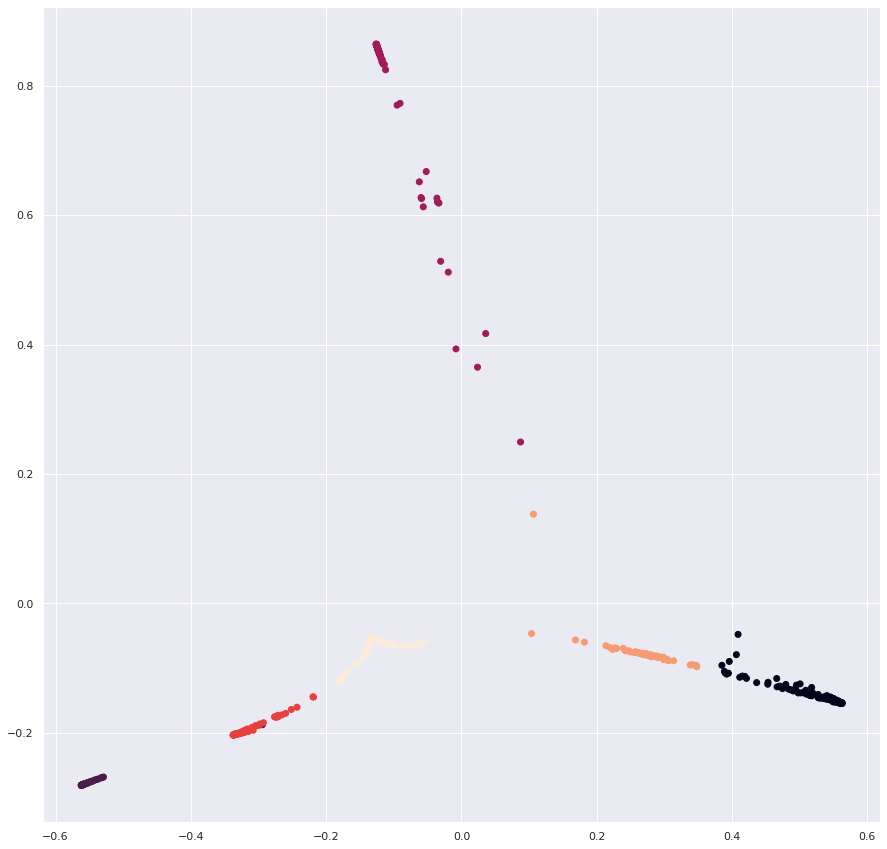

In [62]:
# Visualize embedding after AE with DEC predictions
pca = PCA(n_components=2)
pca_q = pca.fit_transform(q)
plt.scatter(pca_q[:, 0], pca_q[:, 1], c=y_pred)

In [63]:
# Repartition of the label
pd.DataFrame(y_pred).value_counts()

0    106
4     77
3     76
2     73
1     68
5     49
dtype: int64